<a href="https://colab.research.google.com/github/jameVee/Task-Scheduling-Problem-using-PSO/blob/main/PSO_bio_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Task Scheduling Problem using PSO**

ปัญหาการจัดตารางการผลิตแบบไหลยืดหยุ่นโดยมีวัตถูประสงค์เพื่อให้เวลางานล่าช้ารวมน้อยที่สุด

อ้างอิง : 
http://www.dms.eng.su.ac.th/filebox/FileData/POM019.pdf

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random as rd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
nPartical = 7 # จำนวนpartical 
nProblem = 20 # จำนวนงาน
iteration = 20 # จำนวนรอบในการบิน
w = 0.4
n1 = 0.3
n2 = 0.3
num_machine = 3
data = pd.read_excel('/content/drive/MyDrive/PSO_bio_project/task_scheduling_PSO.xlsx',sheet_name='Sheet1')

กำหนดให้ 1 สถานีมี 1 เครื่องจักร

In [ ]:
data  

,งาน\สถานี,1,2,3,due_date
0,1,4,10,4,9
1,2,1,1,10,5
2,3,1,1,8,4
3,4,2,3,8,8
4,5,9,2,3,7
5,6,9,9,2,5
6,7,4,6,8,10
7,8,3,4,5,7
8,9,5,2,3,8
9,10,8,8,9,3


D คือ Due date vector
สร้างได้โดยใช้ due_date ของแต่ละงาน

In [ ]:
range_duedate = int( (max(data.due_date) - min(data.due_date)) / 3 )
D = np.zeros(nProblem)
min_duedate = int(min(data.due_date))
max_duedate = int(max(data.due_date))
for g in range(nProblem):
  if min_duedate <= data.due_date[g]<= (min_duedate + range_duedate) :
    D[g] = 2000
  elif  (min_duedate + range_duedate) <= data.due_date[g] <= (max_duedate-range_duedate):
    D[g] = 1000
  else:
    D[g] = 0
D

array([   0., 2000., 2000., 1000., 1000., 2000.,    0., 1000., 1000.,
       2000., 2000.,    0., 1000., 1000.,    0., 2000., 2000., 1000.,
       2000., 2000.])

กำหนดค่าตัวแปรต่างๆ

In [ ]:
# initial
x = np.random.randint(1,100,nProblem*nPartical).reshape(nPartical,nProblem) #ตำแหน่ง
v = np.random.randint(1,50,nProblem*nPartical).reshape(nPartical,nProblem) #ตวามเร็ว
z = x.copy()
PBest = np.zeros(nProblem*nPartical).reshape(nPartical,nProblem)
GBest = np.zeros(nProblem)
Obj = np.full((nPartical,), 9999999.0) #objective of partical
ObjPBest = np.full((nPartical,), 9999999.0)
ObjGBest = 9999999.0
print('x : \n',x)
print('v : \n',v)

x : 
 [[97 57 65  9 61 18 67 13 17 20 63 15 96 88 65  9  4 66 97 19]
 [67 51 93 30 10 11 26 38 24 93 71 91 48 62 38 70 19  9 49 40]
 [ 7  5 62 41 37 68 51 73 94 96 41 82 52 69 37 37 33 95 63 87]
 [ 3 77 49 46 29 45  8 55 95 46 75 28  4 45 64 82 63 12 37 56]
 [94 30 31 61  9 64 83  4 99 19 43 45 77 62 74 51 10 39 80 62]
 [38 16 50 14 84 92 91  3 62 87 30 34 12  4 24 68 87 39 57 92]
 [69 40 91 95 68 31 39  1 75 45 59 56 57 87 14 44 92 89  4 57]]
v : 
 [[41 16 17 24 46 23 23  7  5 14 37  2 37 47 20  4 11 46 46 15]
 [15 34 37 25 42 40 47 29 33 48 37 18 14 17 12 34 37 25 22 29]
 [15  6 42 41 29 39 37 15 43  2 32  1  6 12 42 49  5  2 27 26]
 [19 15 36 41 39 41 49  1 30 14 43 36  6 34 32 29 32 49 30 32]
 [32 16 13 45 25 23  4 47  8  8 12 40 44 31 23 43 30  3 26 39]
 [25 24 21 35 36 17 40 28 40 21 31 23 17 38 23 48  1 28  9 31]
 [33 34 18 44 19 22 36 41 13 40 42 28 41 38 24 30  9 15 27  2]]


ฟังก์ชันในการค่า objective โดยปัญหานี้้หาค่าความล่าช้าที่น้อยที่สุดในการจัดลำดับของงาน

In [ ]:
# find objective
def FindObj(p):
    tmp = z.copy()[p]
    #tmp = x.copy()[p]
    sequence = []
    for i in range(0,nProblem):
        ind = np.unravel_index(np.argmax(tmp, axis=None), tmp.shape)
        sequence.append(ind)
        tmp[ind] = -1

    available_mc = np.ones(num_machine)
    mc_running = np.full((num_machine,), -1)
    time_mc =  np.zeros(num_machine)
    job_done = np.zeros(nProblem)
    date = 0
    s = 0
    job = sequence[s][0]
    obj_value = 0
    while True:
      date += 1
      for i in range(0,len(available_mc)):
          if available_mc[i] == 1:
              time_mc[i] += data[i+1][job]
              available_mc[i] = 0
              mc_running[i] = job
              s += 1
              if s < nProblem:
                  job = sequence[s][0]

      for i in range(0,len(time_mc)):
          if date >= time_mc[i]:
              available_mc[i] = 1
              obj_value += max(0,(time_mc[i] - data.due_date[mc_running[i]]))
              job_done[mc_running[i]] = 1
              mc_running[i] = -1

      if sum(job_done) == nProblem:
          break
    Obj[p] = obj_value

ฟังก์ชันในการแสดงผลลัพธ์ลำดับงาน โดยใช้ค่า GBest



In [ ]:
def showResult():
    tmp = GBest.copy()
    sequence = []
    for i in range(0,nProblem):
        ind = np.unravel_index(np.argmax(tmp, axis=None), tmp.shape)
        sequence.append(ind[0]+1)
        tmp[ind] = -1
    print("Sequence is",sequence)
    print(f"Total Tardiness is {ObjGBest:.2f}")

ฟังก์ชันในการประเมิน โดยหาค่าobjective ของทุก particle

In [ ]:
#evaluate
def evaluation():
    for p in range(0,nPartical):
        FindObj(p)


ฟังก์ชันในการหา PBest โดยถ้าได้ค่าPBestที่น้อยกว่าPBestปัจจุบันจะเปลี่ยนเป็นPBestที่น้อยกว่า

In [ ]:
def find_pbest():
    global z
    for p in range(0,nPartical):
        if ObjPBest[p] > Obj[p]:
            ObjPBest[p] = Obj[p]
            PBest[p] = z[p]

ฟังก์ชันในการหา GBest โดยถ้าได้ค่าGBestที่น้อยกว่าGBestปัจจุบันจะเปลี่ยนเป็นGBestที่น้อยกว่า

In [ ]:
def find_gbest():
    global ObjGBest , GBest
    for p in range(0,nPartical):
        if ObjGBest > ObjPBest[p]:
            ObjGBest = ObjPBest[p]
            GBest = PBest[p]

ฟังก์ชันในการหาอัพเดตค่า x , v โดยค่า z คือค่าxที่บวกกับ due_date vector

In [ ]:
def update_position():
    global w ,n1,n2 , x , v , z
    r1 = rd.random()
    r2 = rd.random()

    #update velocity
    v = w*v + n1*r1*(PBest - x) + n2*r2*(GBest - x)
    #update position
    x = x + v
    #update z
    z = x.copy() + D

In [ ]:
round_iteration = []
value = []

In [ ]:
#main
for i in range(0,iteration):
    evaluation()
    find_pbest()
    find_gbest()
    update_position()

    #เก็บค่ารอบiteration กับ GBest เพื่อใช้ในการplot กราฟความสัมพันธ์
    round_iteration.append(i+1)
    value.append(ObjGBest)

#show result
showResult()

Sequence is [19, 3, 20, 11, 16, 6, 10, 2, 17, 9, 14, 4, 13, 18, 8, 5, 15, 7, 12, 1]
Total Tardiness is 139.00


In [ ]:
print(value)
print(round_iteration)

[276.0, 255.0, 232.0, 232.0, 216.0, 212.0, 193.0, 145.0, 139.0, 139.0, 139.0, 139.0, 139.0, 139.0, 139.0, 139.0, 139.0, 139.0, 139.0, 139.0]
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


กราฟความสัมพันธ์ระหว่าง iteration กับ Tardiness

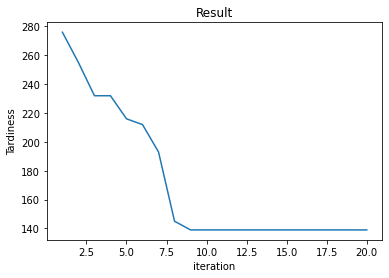

In [ ]:
plt.title('Result')
plt.xlabel('iteration')
plt.ylabel('Tardiness')
plt.plot(round_iteration,value)
plt.show()